# RC Temporal Subsampling
## NRMSE and NRMSE + KE NRMSE Macro Cost

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [2]:
sys.path.append("..") 
from rcgfd import RCDataset, BigPlot, plot_ke_relerr, MetricsPlot

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
rcd = RCDataset(
    n_sub=[4, 16, 48],
    cost_terms = [
        {"nrmse": 1},
        {"nrmse": 1, "spectral": 1e-3},
        {"nrmse": 1, "spectral": 1e-2},
        {"nrmse": 1, "spectral": 1e-1},
        {"nrmse": 1, "spectral": 1.0},
        {"nrmse": 1, "spectral": 10.0},
    ]
)

In [6]:
%%time
ds = rcd()

CPU times: user 52.1 s, sys: 13.8 s, total: 1min 5s
Wall time: 1min 1s


In [7]:
ds["gamma"] = xr.DataArray([0., 1e-3, 1e-2, 1e-1, 1.0, 10.0], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds = ds.swap_dims({"experiment":"gamma"})

Grab one sample for some plotting

In [50]:
xds = ds.sel(sample=49, n_sub=48, gamma=[0, 1e-2, 1.])

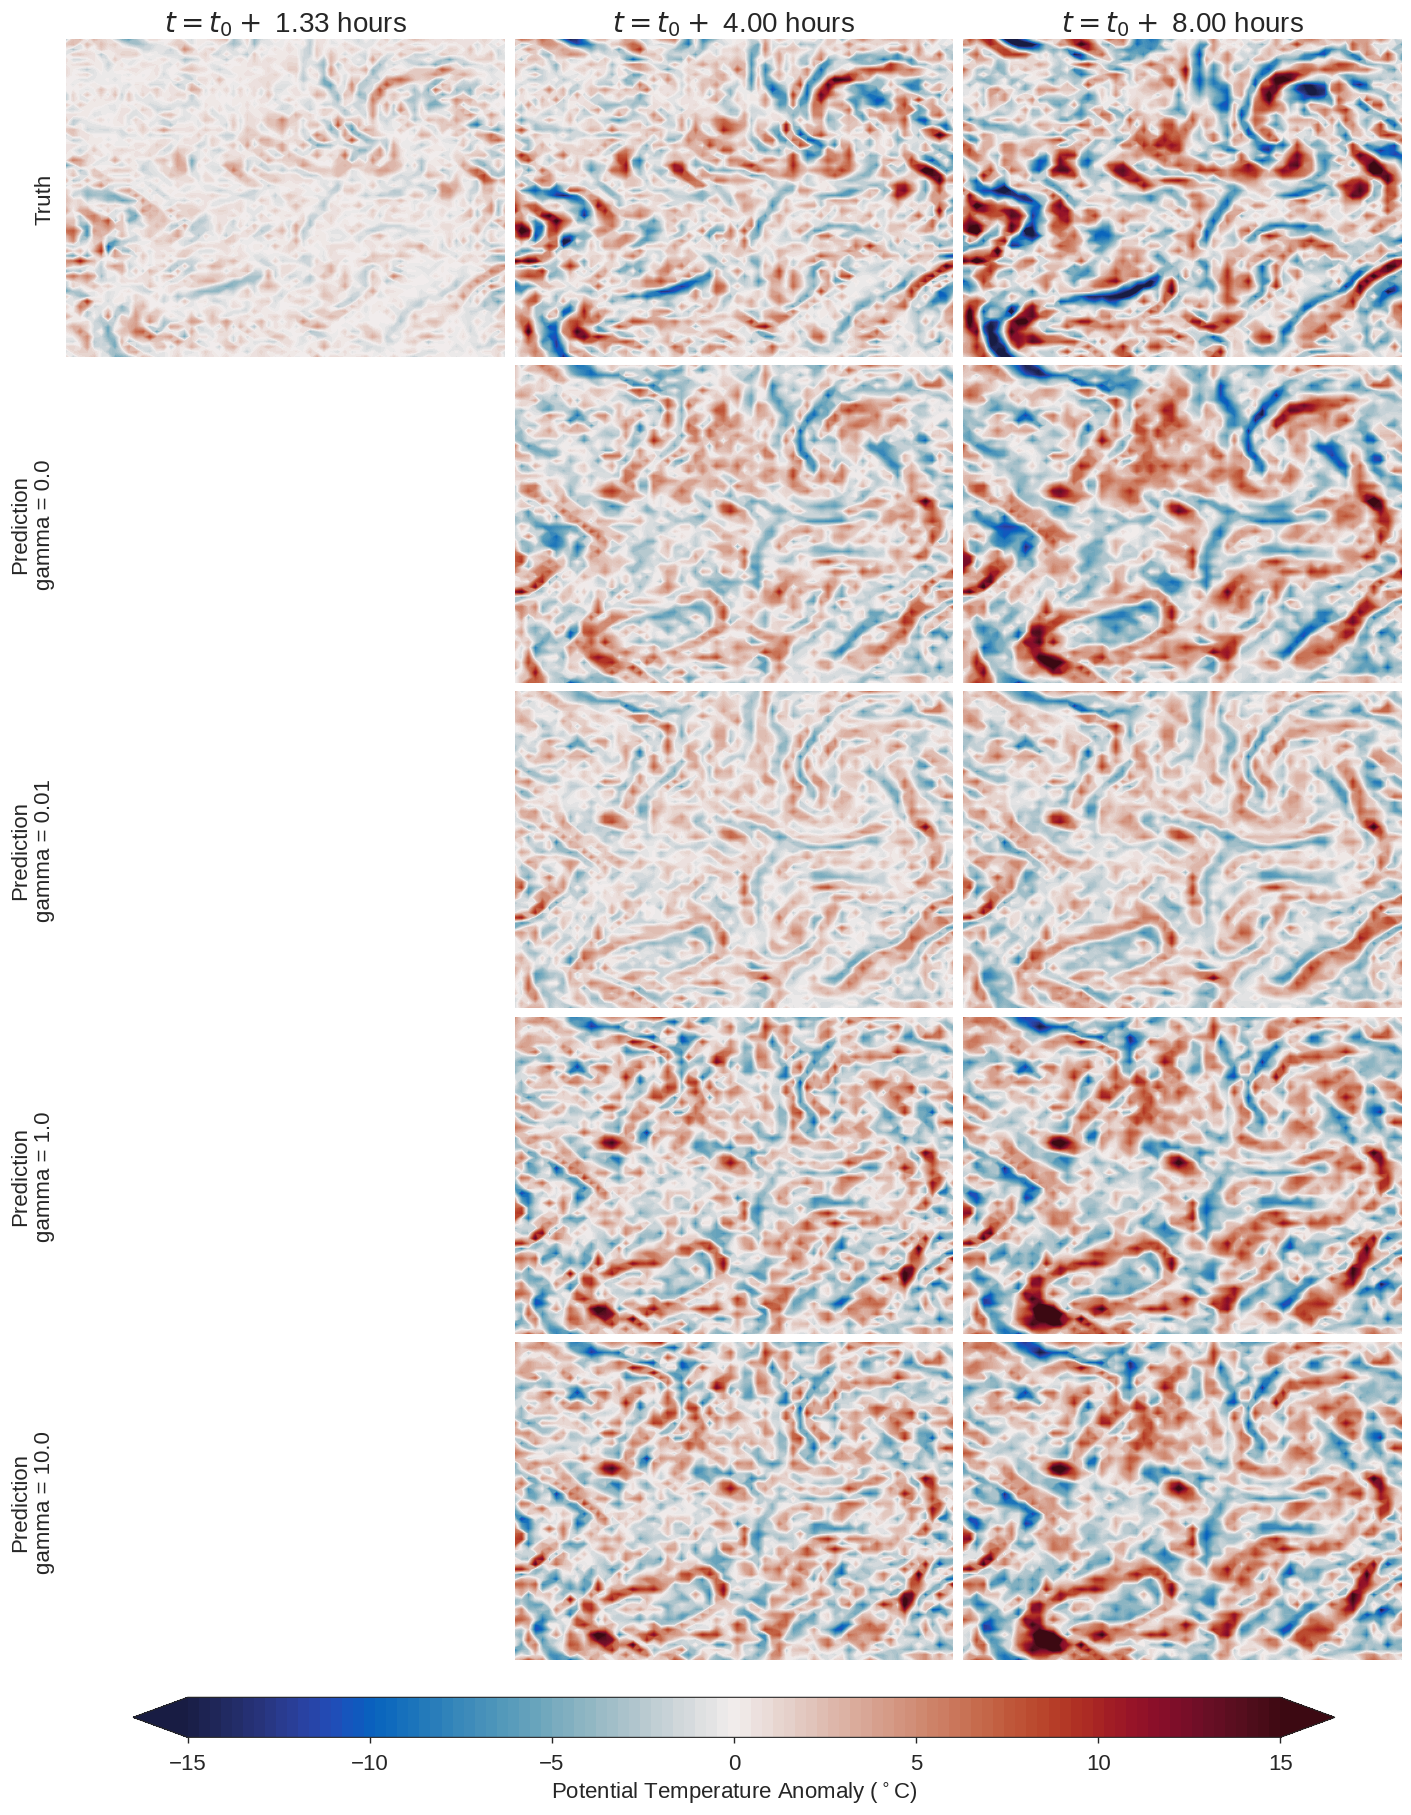

In [51]:
bp = BigPlot()
fig, axs = bp(xds, row_dim="gamma")

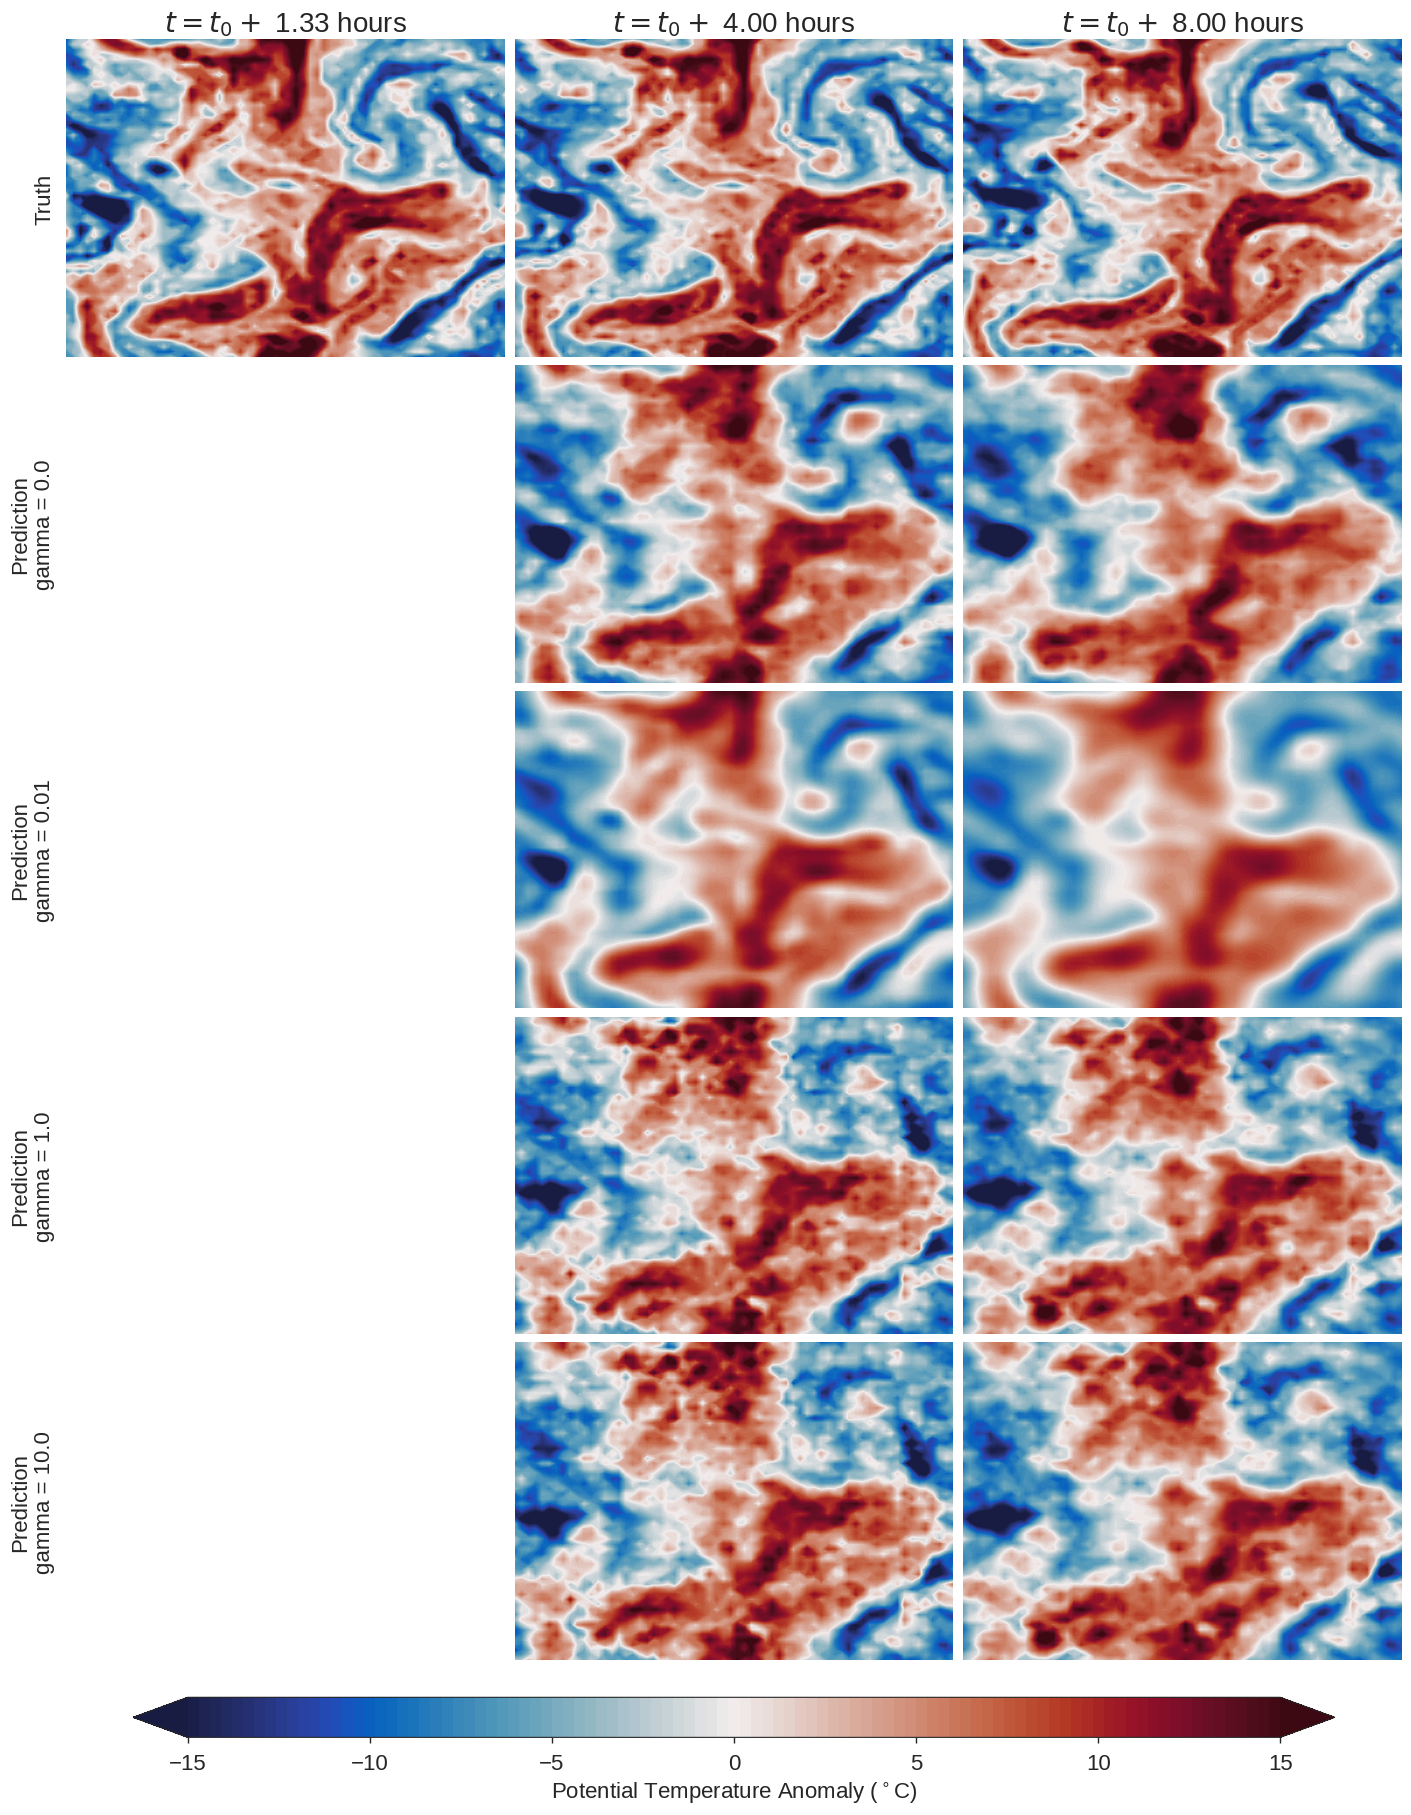

In [52]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds, row_dim="gamma")

## Metrics

- Note that even though the penalty is different here than in the other notebook,
  it is easiest to use KE NRMSE instead of KE RMSE to compare runs
- The NRMSE compares to what the spectrum error shows
- And it doesn't matter how the plots are normalized, but using standard deviation is easier to visualize

In [11]:
ds['nrmse'].load();

In [12]:
ds["ke_relnrmse"] = np.sqrt( (ds["ke_rel_err"]**2).mean("k1d") )

In [13]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="gamma",
)

### $N_{sub}=48$

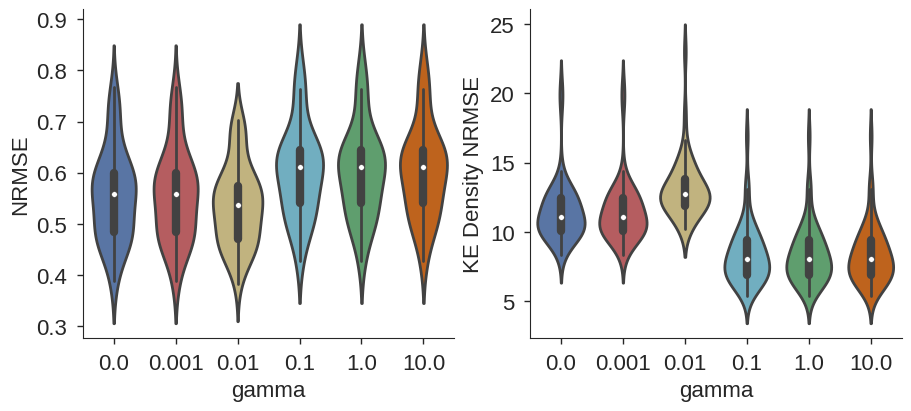

In [14]:
fig, axs = mp(ds.sel(n_sub=48), show_time=False)

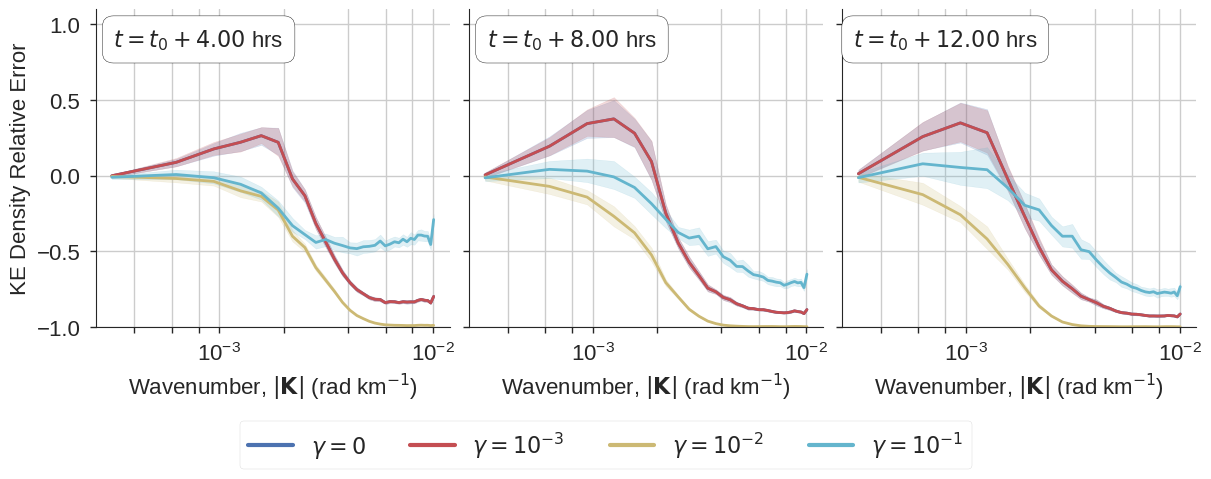

In [20]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=48, gamma=slice(0,.99)),
    hours=(4,8,12),
    cdim="gamma",
    clabel=mp.gamma_label)

### $N_{sub}=16$

In [14]:
fig, axs = mp(ds.sel(n_sub=16), show_time=False)

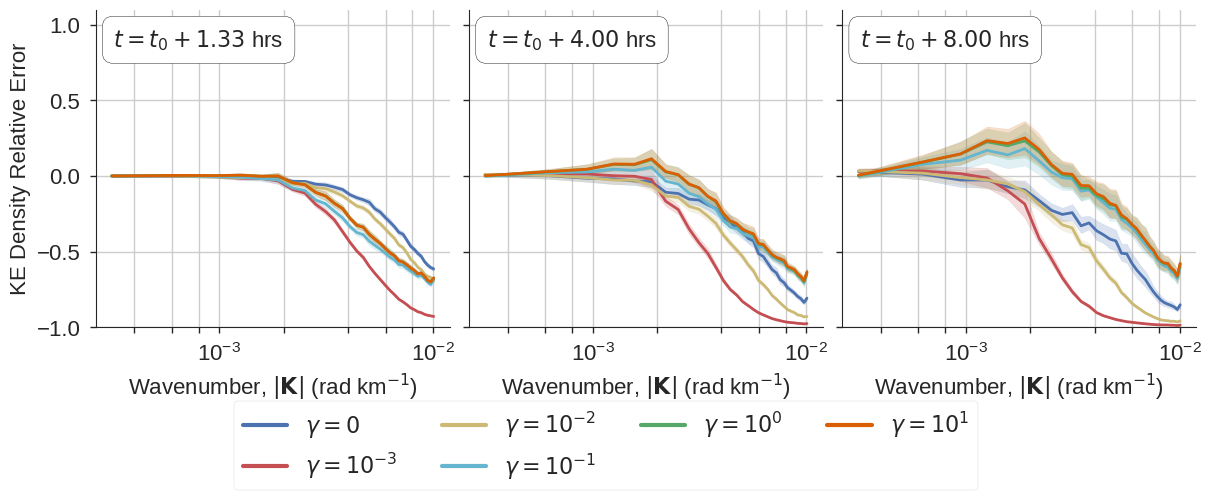

In [15]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=16),
    cdim="gamma",
    clabel=mp.gamma_label)

- Consider either $\gamma = 0$ or $\gamma = 0.1$, we have a tradeoff between NRMSE and KE NRMSE
- However, the KE NRMSE is a bit nuanced here: spectral bias is better at higher wavenumbers
  (about $|\mathbf{K}|\gt 3\cdot10^{-3}$), but there's a tradeoff in the sense that the smaller wavenumbers 
  are worse
- So which is better depends on a matter of taste...
- Similar to KE RMSE case, using an intermediate value of $\gamma$ tends to produce runs that are *more* blurry than
  using $\gamma = 0$.

Even though 

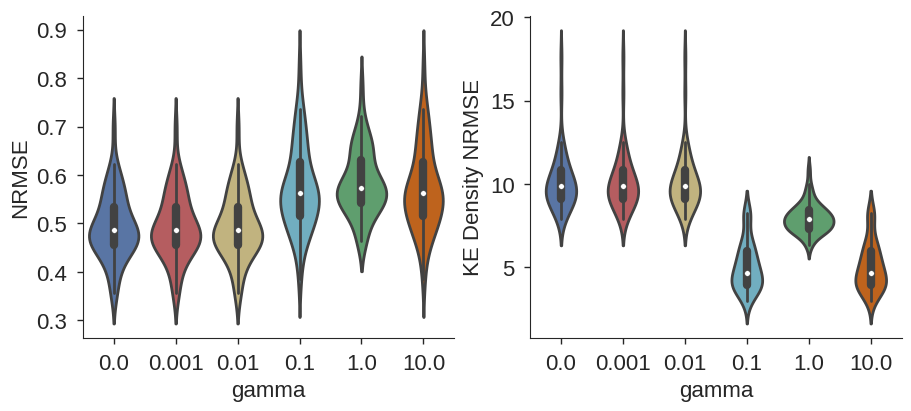

In [16]:
fig, axs = mp(ds.sel(n_sub=4), show_time=False)

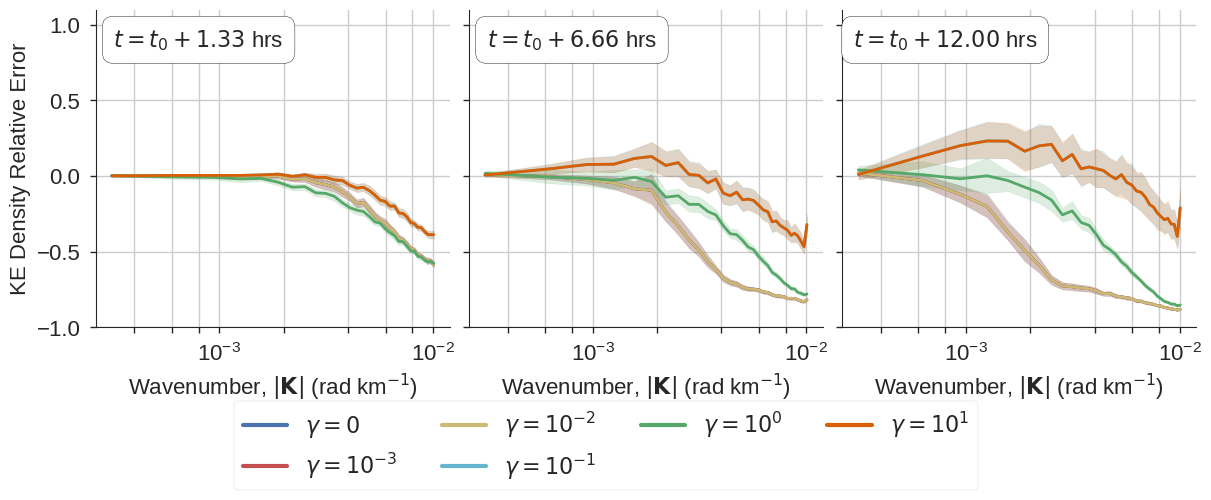

In [23]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=4),
    cdim="gamma",
    hours=(1.33,6.66,12),
    clabel=mp.gamma_label)

## Compare $N_{sub}$

In [24]:
nsp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="n_sub",
)

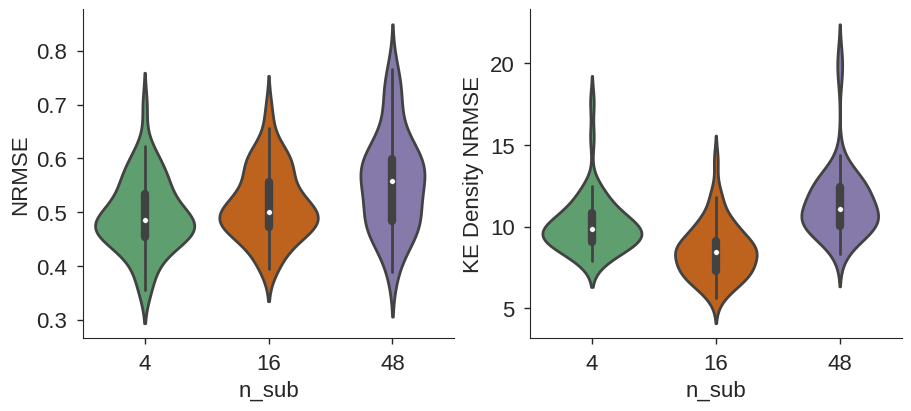

In [42]:
fig, axs = nsp(ds.sel(gamma=0.), show_time=False)

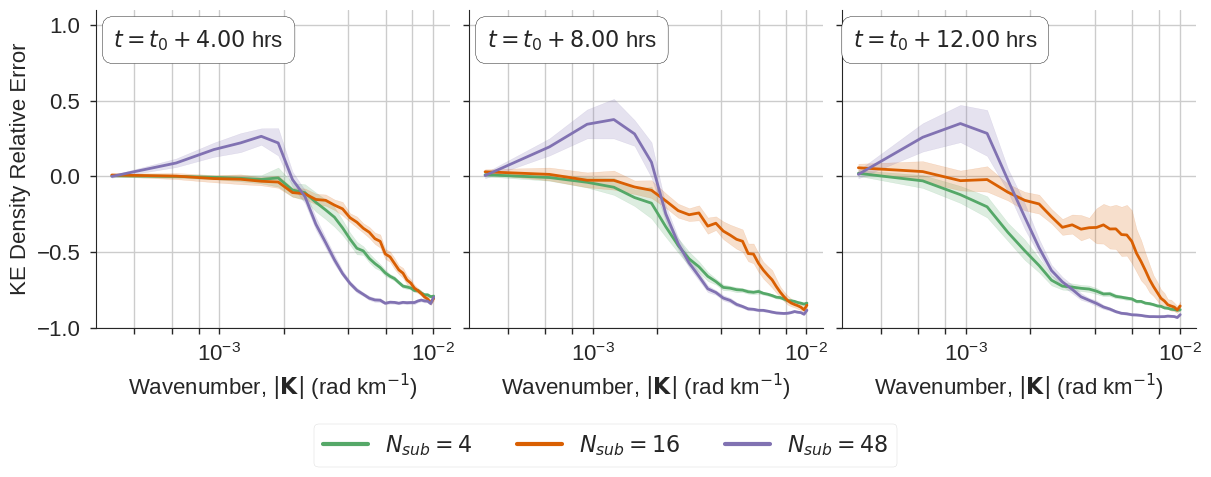

In [46]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=0.),
    cdim="n_sub",
    hours=(4,8,12),
)